## Sumário

1. [Introdução](#1.-Introdução)
2. [EDA e Feature Engineering](#2.-EDA-e-Feature-Engineering)
3. [Clustering](#3.-Clustering)
4. [Escolha de cidade](#4.-Escolha-de-cidade)
5. [Modelo de classificação](#5.-Modelo-de-classificação)

   [Referências](#Referências)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore'
)

## 1. Introdução

Esse notebook tem como objetivo fornecer uma solução para o case proposto. Dessa forma, busca-se executar as atividades abaixo:

1. Classificar e caracterizar os municípios com base nos dados demográficos;
2. Identificar e justificar quais os municípios mais adequados para a entrada da empresa no mercado brasileiro;
3. Elaborar um modelo de classificação para identificar a qual grupo o município pertence.

São feitas algumas considerações sobre qual seria o ambiente ideal para produzir a população ideal para consumir bebidas industrializadas.

1. Conforme [1] e [2], o consumo de bebidas industrializadas é mais prevalente dentre a população mais jovem. Dessa forma, busca-se cidades que possuam alta taxa de crescimento populacional e um bom percentual de pessoas até 25 anos.

2. Conforme [3], o consumo de bebidas industrializadas é mais prevalente dentre a população de maior renda. Dessa forma busca-se cidades que possuam renda per capita alta e baixos indices de pobreza.

3. Entende-se que grandes cidades são adequadas por possuirem um potencial de clientes maior, além de possuir mais mão de obra para contratação, visto que a empresa ainda não está implantada. Dessa forma, busca-se cidades com alta taxa de crescimento populacional e grande quantidade de população.

4. Entende-se que populações mais urbanas apresentam maior facilidade para aceitar novos produtos. Dessa forma, busca-se cidades que tenham alto percentual de população urbana e que estejam próximas das capitais.

5. Por último, vale olhar para cases recentes de outros players, tal como o lançamento do Clash'd pela Heineken [4]. Os estados escolhidos pelo player (SP, RJ, MG, PR) concorrente devem ser levadas em consideração visto que provavelmente houve um extenso estudo antes da escolha.

Destaca-se que os dados das pesquisas não são recentes, no entanto os dados demográficos disponíveis também datam de 1991 e 2000, portanto há essa ressalva quanto a validade da análise desenvolvida.

## 2. EDA e Feature Engineering

Seleciona-se apenas as colunas de interesse conforme as considerações feitas na introdução. As colunas são renomeadas para facilitar o uso.

As features que serão utilizadas são:

1. Distância da capital
2. Taxa de fecundidade total em 2000
3. Renda per Capita
4. Intensidade de pobreza
5. % de População até 25 anos
6. População de até 25 anos em 2000
7. Taxa de crescimento da população de até 25 anos
8. % de População urbana

Das quais as features 1 a 4 já estão prontas no dataset original e as features 5 a 8 serão obtidas.

In [2]:
cities_raw = pd.read_excel('data/raw_data.xls')

cities = cities_raw[[
    'Código',
    'Município',
    'UF',
    'Distância à capital (km)',
    'Taxa de fecundidade total, 2000',
    'Renda per Capita, 2000',
    'Intensidade da pobreza, 2000',
    'População de 25 anos ou mais de idade, 2000',
    'População de 25 anos ou mais de idade, 1991',
    'População total, 2000',
    'População total, 1991',
    'População urbana, 2000'
]]

cities.rename(columns={
    'Código': 'id',
    'Município': 'municipio',
    'UF': 'uf',
    'Distância à capital (km)': 'dist_cap_km',
    'Taxa de fecundidade total, 2000': 'taxa_fec',
    'Renda per Capita, 2000': 'renda_cap',
    'Intensidade da pobreza, 2000': 'pobreza',
    'População de 25 anos ou mais de idade, 2000': 'pop_25_mais_2000',
    'População de 25 anos ou mais de idade, 1991': 'pop_25_mais_1991',
    'População total, 2000': 'pop_total_2000',
    'População total, 1991': 'pop_total_1991',
    'População urbana, 2000': 'pop_urb_2000'
}, inplace=True)

cities.set_index(['id'], inplace=True)

Nota-se que não existem colunas com dados faltantes. Pelos boxplots percebe-se que existem outliers, mas isso é natual do dataset, existe a tendência de concentração de pessoas em grandes cidades, por exemplo. Dessa forma, não será necessário esforço para o tratamento dos dados.

In [3]:
cities.describe()

,dist_cap_km,taxa_fec,renda_cap,pobreza,pop_25_mais_2000,pop_25_mais_1991,pop_total_2000,pop_total_1991,pop_urb_2000
count,5507.000000,5507.000000,5507.000000,5507.000000,5.507000e+03,5.507000e+03,5.507000e+03,5.507000e+03,5.507000e+03
mean,253.212620,2.864845,170.814160,47.086060,1.551693e+04,1.221264e+04,3.083333e+04,2.666167e+04,2.505066e+04
std,163.210532,0.744454,96.425347,10.732511,1.039028e+05,8.923783e+04,1.867506e+05,1.690004e+05,1.800123e+05
min,0.000000,1.560000,28.380000,15.760000,4.220000e+02,2.390000e+02,7.950000e+02,6.180000e+02,0.000000e+00
25%,121.858906,2.320000,86.495000,38.190000,2.502000e+03,2.119500e+03,5.152500e+03,4.945000e+03,2.402500e+03
50%,228.262939,2.670000,159.100000,46.230000,4.930000e+03,4.084000e+03,1.041800e+04,9.748000e+03,5.314000e+03
75%,358.072044,3.230000,232.695000,55.410000,1.004000e+04,8.104000e+03,2.135650e+04,1.897450e+04,1.324050e+04
max,1474.314590,7.790000,954.650000,83.030000,5.825893e+06,5.106165e+06,1.043425e+07,9.649519e+06,9.813187e+06


In [4]:
# Comentado para facilitar a leitura do documento. Pode ser descomentado durante análises detalhadas.

# for column in cities.select_dtypes(exclude=['object']):
#     plt.figure()
#     cities.boxplot([column])

In [5]:
cities['pop_ate_25_2000'] = cities['pop_total_2000'] - cities['pop_25_mais_2000']
cities['pop_ate_25_1991'] = cities['pop_total_1991'] - cities['pop_25_mais_1991']

cities['perc_ate_25_2000'] = cities['pop_ate_25_2000'] / cities['pop_total_2000']
cities['var_pop_ate_25'] = cities['pop_ate_25_2000'] / cities['pop_ate_25_1991']

cities['perc_pop_urb'] = cities['pop_urb_2000'] / cities['pop_total_2000']

ids = cities[['municipio', 'uf']]
cities = cities[[
    'dist_cap_km',
    'taxa_fec',
    'renda_cap',
    'pobreza',
    'pop_ate_25_2000',
    'perc_ate_25_2000',
    'var_pop_ate_25',
    'perc_pop_urb',
]]

cities.to_csv('data/cities.csv', index=True)
del(cities_raw)

## 3. Clustering

Optou-se pela clusterização das cidades utilizando K Means. Os dados foram escalados e o modelo foi aplicado usando as 8 features desenvolvidas. Houve a divisão em três grupos de cidades.

Os clusters podem ser classificados por:

Cluster 0: Cidades urbanas. Esse grupo é composto pelas cidades que têm características mais urbanas, tal como menor distância da capital, menores taxa de fecundidade, maior renda per capita, maiores populações e alto percentual de população em área urbana.

Cluster 1: Microcidades. Cidades com em média 5 mil habitantes. Essas cidades são as de menor interesse comercial, visto que sua população é muito pequena e portanto seu potencial de receita é limitado.

Cluster 2: Pequenas cidades. Cidades com em média 10 mil habitantes, ainda não são suficientes para despertar interesse comercial, pois apesar de maiores, destaca-se a maior distância das capitais, maiores índices de pobreza e menor renda per capita.

In [6]:
scaler = MinMaxScaler()
cities_scaled = pd.DataFrame(
    scaler.fit_transform(cities),
    index=cities.index,
    columns=cities.columns,
)

In [7]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit(cities_scaled)
cities['cluster'] = clusters.labels_
cities_grouped_by_cluster = cities.groupby('cluster').mean().reset_index()
cities.groupby('cluster').count()['dist_cap_km']

cluster
0    2294
1    1135
2    2078
Name: dist_cap_km, dtype: int64

In [8]:
def plot_barplot_clusters(df: pd.DataFrame, features: list, title: str):
  f, ax = plt.subplots(1, len(features), figsize=(18, 5))
  f.suptitle(title)

  for pos, feature in enumerate(features):  
      sns.barplot(ax=ax[pos], x='cluster', y=features[pos], data=df)
      
  return f

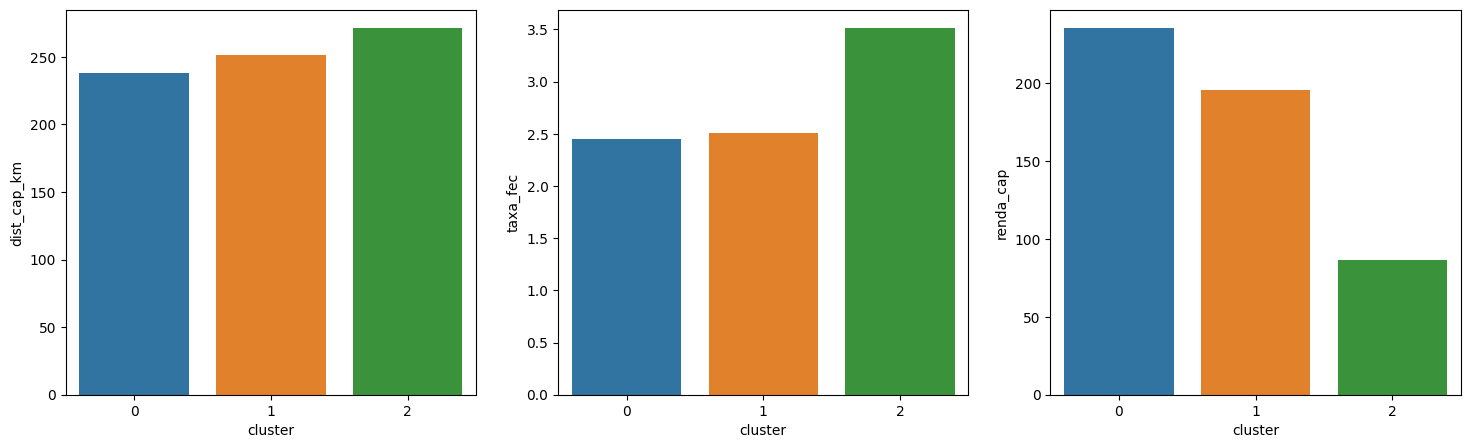

In [9]:
plot_barplot_clusters(
  cities_grouped_by_cluster,
  ['dist_cap_km', 'taxa_fec', 'renda_cap'],
  '',
).show()

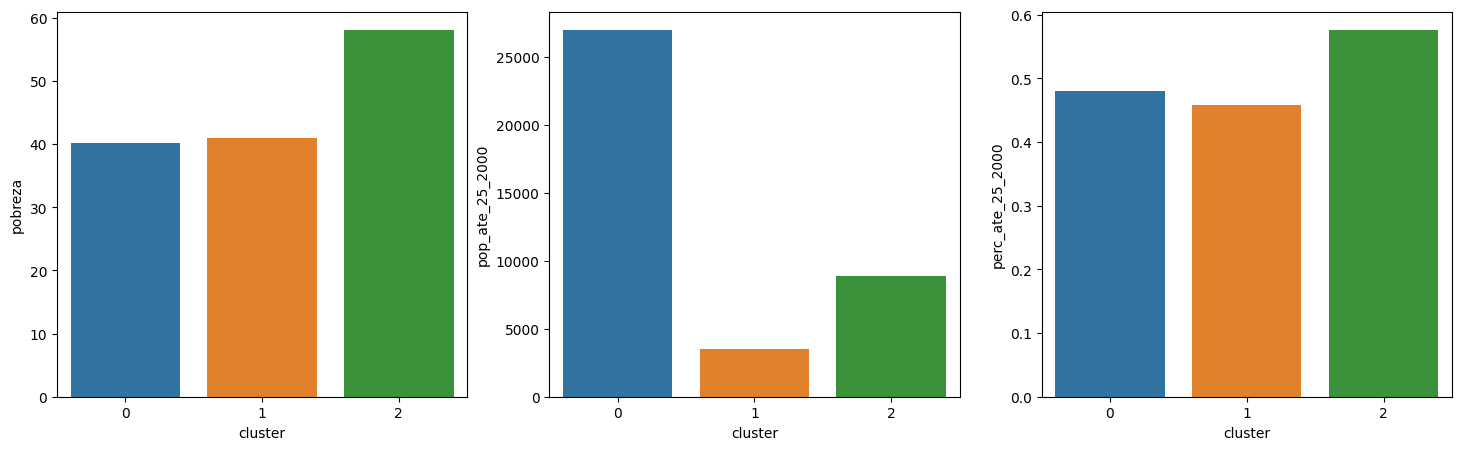

In [10]:
plot_barplot_clusters(
  cities_grouped_by_cluster,
  ['pobreza', 'pop_ate_25_2000', 'perc_ate_25_2000'],
  '',
).show()

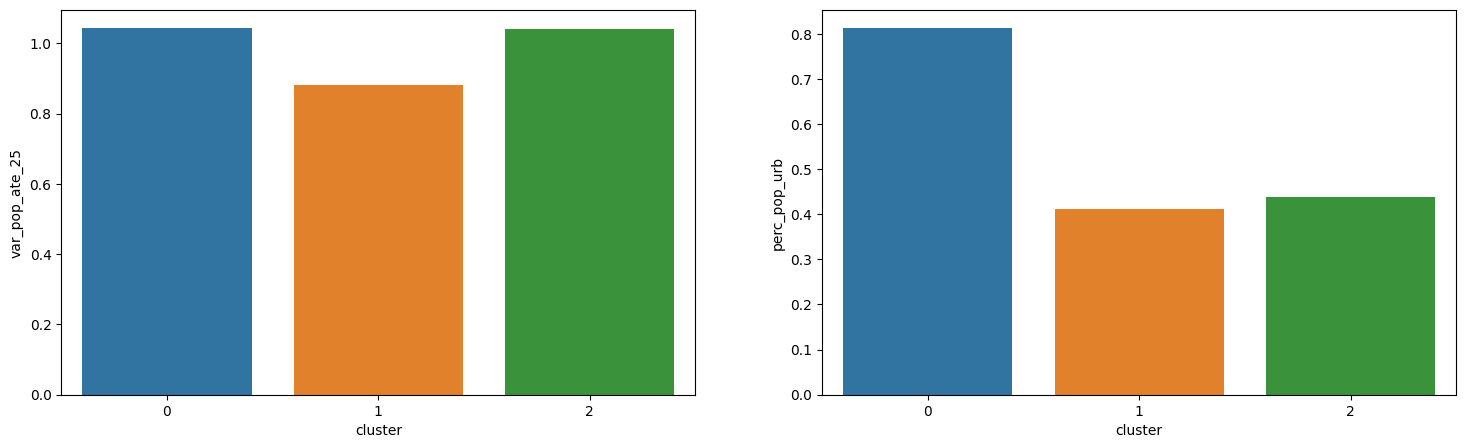

In [11]:
plot_barplot_clusters(
  cities_grouped_by_cluster,
  ['var_pop_ate_25', 'perc_pop_urb'],
  '',
).show()

In [12]:
cities = cities.join(ids, on='id')

## 4. Escolha de cidade

Relembrando os pontos destacados como importantes na introdução, busca-se:

* Uma população volumosa, urbana, com alto percentual de jovens e com alta renda per capita.

A cidade que representa melhor os pontos destacados é São Paulo. Seus indicadores de taxa de fecundidade e variação de população podem ser menores que outras grandes cidades como Fortaleza, mas o tamanho e renda da população destoam. Junto a isso pode-se considerar outros fatores como:

1. Presença de portos para recebimento de insumos/mercadoria pronta.
2. Maior facilidade para contratação de mão de obra.
3. Outros grandes players chegando a conclões similares [4]

In [13]:
cities.sort_values('pop_ate_25_2000', ascending=False).head(10)

,dist_cap_km,taxa_fec,renda_cap,pobreza,pop_ate_25_2000,perc_ate_25_2000,var_pop_ate_25,perc_pop_urb,cluster,municipio,uf
id,,,,,,,,,,,
355030,0.0,1.88,610.04,51.19,4608359,0.441657,1.014308,0.940478,0,São Paulo,SP
330455,0.0,1.87,596.65,46.90,2346406,0.400554,1.017949,1.000000,0,Rio de Janeiro,RJ
292740,0.0,1.69,341.32,46.31,1195913,0.489505,1.047264,0.999589,0,Salvador,BA
230440,0.0,2.16,306.70,43.73,1080368,0.504514,1.105817,1.000000,0,Fortaleza,CE
530010,0.0,1.96,605.41,42.23,1042300,0.508155,1.163625,0.956294,0,Brasília,DF
310620,0.0,1.65,557.44,40.64,997385,0.445554,0.997346,1.000000,0,Belo Horizonte,MG
130260,0.0,2.55,262.40,49.67,792605,0.563797,1.289839,0.993550,0,Manaus,AM
410690,0.0,1.74,619.82,43.76,707238,0.445556,1.092214,1.000000,0,Curitiba,PR
261160,0.0,1.81,392.46,44.77,657313,0.461951,0.964959,1.000000,0,Recife,PE


## 5. Modelo de classificação

Para modelagem optou-se por testar o mais simples e interpretável primeiro, dessa forma observou-se que os resultados de precisão para a árvore de decisão testada em um Cross Validation de 5 folds foi de mais de 90%.

Em seguida testou-se qual seria a profundidade máxima da árvore ideal por um Grid Search para evitar overfit, chegando a profundidade máxima de 4 nós a uma precisão superior a 95%.

In [14]:
def eval_model(x: pd.DataFrame, y: pd.Series, model):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
  cv_results = cross_validate(
    model,
    x,
    y,
    cv=skf,
    scoring=['accuracy'],
  )
  return cv_results['test_accuracy'].mean()

def grid_search_model(x: pd.DataFrame, y: pd.Series, model, params: dict):
  grid_search = GridSearchCV(
    model,
    params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    return_train_score=True,
  )
  grid_search.fit(x, y)
  return pd.DataFrame(grid_search.cv_results_)

def plot_overfit_analysis(
  df: pd.DataFrame,
  x_label: str,
  y_label: str,
  title: str,
):
  f, ax = plt.subplots(figsize=(7, 5))
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  sns.lineplot(
    x='param_max_depth',
    y='mean_test_score',
    data=df,
    label='Test'
  )
  sns.lineplot(
    x='param_max_depth',
    y='mean_train_score',
    data=df,
    label='Train'
  )
  plt.legend()
  return f

In [15]:
tree = DecisionTreeClassifier(random_state=0)
tree_results = eval_model(cities_scaled, clusters.labels_, tree)
tree_results

0.9620486902683749

In [16]:
params = {'max_depth': [i for i in range(1, 20)]}
grid_search_results = grid_search_model(cities_scaled, clusters.labels_, DecisionTreeClassifier(), params)

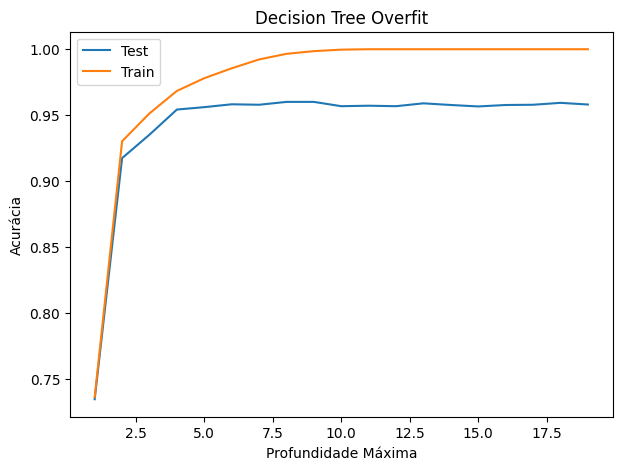

In [17]:
plot_overfit_analysis(
  grid_search_results,
  'Profundidade Máxima',
  'Acurácia',
  'Decision Tree Overfit'
).show()

## Referências

[1. Pesquisa AFEBRAS - Idade](https://afrebras.org.br/noticias/pesquisa-revela-quem-consome-mais-refrigerante-no-pais/)

[2. Artigo UFPA - Idade](https://coesa.ufpa.br/arquivos/2018/expandido/pesquisa/epidemiologia/PES207.pdf)

[3. Pesquisa IBGE - Renda](https://www.uol.com.br/vivabem/noticias/redacao/2011/07/28/brasileiros-consomem-mais-de-15-milhoes-de-litros-de-refrigerante-por-dia-aponta-ibge.htm)

[4. Lançamento concorrente](https://www.heinekenbrasil.com.br/noticias/clash-d-grupo-heineken-inova-ao-lancar-primeiro-refrigerante-brewed-do-mercado-brasileiro/#)